In [133]:
import zdb
import glob
import os
import oyaml as yaml

In [13]:
help(zdb.modules.analyse)

Help on function analyse in module zdb.modules.analyse:

analyse(config, mode='multiprocesing', ncores=0, nfiles=-1, batch_opts='', output=None, chunksize=500000, merge_opts={})



## Data

In [3]:
def generate_yaml(hists, selection, filepath, mc=False):
    hists_def = {
        k: [
            {"table": "df: '{table_name}'"},
            {"varname0": "df: '{}'".format(k)},
            {"selection": "df: '{selection_name}'"},
            {"parent": "df: df.parent"},
            {"binvar0": "df: df.{}_bin".format(k)},
            {"count": "df: 1."},
            {"sum_w": "df: {weight}"},
            {"sum_ww": "df: df.sum_w**2"},
        ] for k in hists
    }
    
    monojet_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5"]
    monojetqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5"]
    singlemuon_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonqcd_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuon_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singleelectron_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    singleelectronqcd_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX<=0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    doubleelectron_selection = selection + ["SingleElectronTriggered", "MinDPhiJ1234METnoX>0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singletau_selection = selection + ["METTriggered", "MinDPhiJ1234METnoX>0.5", "nTauSelection==1"]
    singlemuonmu_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonmuqcd_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuonmu_selection = selection + ["SingleMuonTriggered", "MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    if not mc:
        monojet_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        monojetqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        singlemuon_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuon_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        singleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        doubleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        singletau_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==1"])
        singlemuonmu_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonmuqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmu_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
    else:
        monojet_selection.extend(["nTauSelection==0"])
        monojetqcd_selection.extend(["nTauSelection==0"])
        singlemuon_selection.extend(["nTauSelection==0"])
        singlemuonqcd_selection.extend(["nTauSelection==0"])
        doublemuon_selection.extend(["nTauSelection==0"])
        singleelectron_selection.extend(["nTauSelection==0"])
        singleelectronqcd_selection.extend(["nTauSelection==0"])
        doubleelectron_selection.extend(["nTauSelection==0"])
        singlemuonmu_selection.extend(["nTauSelection==0"])
        singlemuonmuqcd_selection.extend(["nTauSelection==0"])
        doublemuonmu_selection.extend(["nTauSelection==0"])

    cutflows = {
        "Monojet": {
            "selection_name": "Monojet",
            "selection": "(" + ") & (".join(monojet_selection)+")",
            "weight": "1." if not mc else "df.Weight_Monojet",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MTW", "MLL", "Muon", "Electron", "Tau",
            ])],
        },
        "MonojetQCD": {
            "selection_name": "MonojetQCD",
            "selection": "(" + ") & (".join(monojetqcd_selection)+")",
            "weight": "1." if not mc else "df.Weight_MonojetQCD",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MTW", "MLL", "Muon", "Electron", "Tau",
            ])],
        },
        "SingleMuon": {
            "selection_name": "SingleMuon",
            "selection": "(" + ") & (".join(singlemuon_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuon",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "SingleMuonQCD": {
            "selection_name": "SingleMuonQCD",
            "selection": "(" + ") & (".join(singlemuonqcd_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuonQCD",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "DoubleMuon": {
            "selection_name": "DoubleMuon",
            "selection": "(" + ") & (".join(doublemuon_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuon",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MTW", "Electron", "Tau",
            ])],
        },
        "SingleElectron": {
            "selection_name": "SingleElectron",
            "selection": "(" + ") & (".join(singleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleElectron",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "Muon", "SecondElectron", "Tau",
            ])],
        },
        "SingleElectronQCD": {
            "selection_name": "SingleElectronQCD",
            "selection": "(" + ") & (".join(singleelectronqcd_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleElectronQCD",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "Muon", "SecondElectron", "Tau",
            ])],
        },
        "DoubleElectron": {
            "selection_name": "DoubleElectron",
            "selection": "(" + ") & (".join(doubleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleElectron",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MTW", "Muon", "Tau",
            ])],
        },
        "SingleTau": {
            "selection_name": "SingleTau",
            "selection": "(" + ") & (".join(singletau_selection) + ")",
            "weight": "1." if not mc else "df.Weight_SingleTau",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "MTW", "Muon", "Electron",
            ])],
        },
        "SingleMuonMu": {
            "selection_name": "SingleMuonMu",
            "selection": "(" + ") & (".join(singlemuonmu_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuonMu",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "SingleMuonMuQCD": {
            "selection_name": "SingleMuonMuQCD",
            "selection": "(" + ") & (".join(singlemuonmuqcd_selection)+")",
            "weight": "1." if not mc else "df.Weight_SingleMuonMuQCD",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MLL", "SecondMuon", "Electron", "Tau",
            ])],
        },
        "DoubleMuonMu": {
            "selection_name": "DoubleMuonMu",
            "selection": "(" + ") & (".join(doublemuonmu_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuonMu",
            "hists": [h for h in hists_def.keys() if h.startswith("n") or not any(test in h for test in [
                "MTW", "Electron", "Tau",
            ])],
        },
    }

    met_triggers = [
        "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
        "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
        "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
        "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
        "(df.HLT_PFMET170_NotCleaned & (df.run<276282))",
        "(df.HLT_PFMET170_BeamHaloCleaned & (df.run<276282))",
        "df.HLT_PFMET170_HBHECleaned",
        "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
        "df.HLT_MET75_IsoTrk50",
    ]
    if mc:
        met_triggers = [
            "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
            "df.HLT_PFMET170_NotCleaned",
            "df.HLT_PFMET170_BeamHaloCleaned",
            "df.HLT_PFMET170_HBHECleaned",
            "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
            "df.HLT_MET75_IsoTrk50",
        ]
        
    singlemuon_triggers = ["df.HLT_IsoMu24", "df.HLT_IsoTkMu24"]
    singleelectron_triggers = ["df.HLT_Ele27_WPTight_Gsf"]

    cfg_eval_bins = [
        {"METnoX_pt_bin": "df: np.floor(df.METnoX_pt/5.)*5"},
        {"METnoX_phi_bin": "df: np.floor(df.METnoX_phi/0.06283)*0.06283"},
        {"METnoX_sumEt_bin": "df: np.floor(df.METnoX_sumEt/50.)*50"},
        {"MET_pt_bin": "df: np.floor(df.MET_pt/5.)*5"},
        {"MET_phi_bin": "df: np.floor(df.MET_phi/0.06283)*0.06283"},
        {"MET_sumEt_bin": "df: np.floor(df.MET_sumEt/50.)*50"},
        {"CaloMET_pt_bin": "df: np.floor(df.CaloMET_pt/5.)*5"},
        {"CaloMET_phi_bin": "df: np.floor(df.CaloMET_phi/0.06283)*0.06283"},
        {"CaloMET_sumEt_bin": "df: np.floor(df.CaloMET_sumEt/50.)*50"},
        {"PuppiMET_pt_bin": "df: np.floor(df.PuppiMET_pt/5.)*5"},
        {"PuppiMET_phi_bin": "df: np.floor(df.PuppiMET_phi/0.06283)*0.06283"},
        {"PuppiMETnoX_pt_bin": "df: np.floor(df.PuppiMETnoX_pt/5.)*5"},
        {"PuppiMETnoX_phi_bin": "df: np.floor(df.PuppiMETnoX_phi/0.06283)*0.06283"},
        {"MET_dCaloMET_bin": "df: np.floor(df.MET_dCaloMET/0.02)*0.02"},
        {"MinDPhiJ1234METnoX_bin": "df: np.floor(df.MinDPhiJ1234METnoX/0.05)*0.05"},
        {"MinDPhiJ1234PuppiMETnoX_bin": "df: np.floor(df.MinDPhiJ1234PuppiMETnoX/0.05)*0.05"},
        {"MTW_bin": "df: np.floor(df.MTW/4.)*4"},
        {"MLL_bin": "df: np.floor(df.MLL/0.5)*0.5"},
        {"nJetVeto_bin": "df: np.floor(df.nJetVeto/1.)*1"},
        {"nJetSelection_bin": "df: np.floor(df.nJetSelection/1.)*1"},
        {"LeadJetSelection_pt_bin": "df: np.floor(df.LeadJetSelection_pt/5.)*5"},
        {"LeadJetSelection_eta_bin": "df: np.floor(df.LeadJetSelection_eta/0.1)*0.1"},
        {"LeadJetSelection_phi_bin": "df: np.floor(df.LeadJetSelection_phi/0.06283)*0.06283"},
        {"LeadJetSelection_chHEF_bin": "df: np.floor(df.LeadJetSelection_chHEF/0.01)*0.01"},
        {"LeadJetSelection_neHEF_bin": "df: np.floor(df.LeadJetSelection_neHEF/0.01)*0.01"},
        {"SecondJetSelection_pt_bin": "df: np.floor(df.SecondJetSelection_pt/5.)*5"},
        {"SecondJetSelection_eta_bin": "df: np.floor(df.SecondJetSelection_eta/0.1)*0.1"},
        {"SecondJetSelection_phi_bin": "df: np.floor(df.SecondJetSelection_phi/0.06283)*0.06283"},
        {"LeadJetFwdSelection_pt_bin": "df: np.floor(df.LeadJetFwdSelection_pt/1.)*1"},
        {"LeadJetFwdSelection_eta_bin": "df: np.floor(df.LeadJetFwdSelection_eta/0.1)*0.1"},
        {"LeadJetFwdSelection_phi_bin": "df: np.floor(df.LeadJetFwdSelection_phi/0.06283)*0.06283"},
        {"NearestJetSelectionMET_pt_bin": "df: np.floor(df.NearestJetSelectionMET_pt/1.)*1"},
        {"NearestJetSelectionMET_eta_bin": "df: np.floor(df.NearestJetSelectionMET_eta/0.1)*0.1"},
        {"NearestJetSelectionMET_phi_bin": "df: np.floor(df.NearestJetSelectionMET_phi/0.06283)*0.06283"},
        {"nMuonVeto_bin": "df: np.floor(df.nMuonVeto/1.)*1"},
        {"nMuonSelection_bin": "df: np.floor(df.nMuonSelection/1.)*1"},
        {"LeadMuonSelection_pt_bin": "df: np.floor(df.LeadMuonSelection_pt/5.)*5"},
        {"LeadMuonSelection_eta_bin": "df: np.floor(df.LeadMuonSelection_eta/0.1)*0.1"},
        {"LeadMuonSelection_phi_bin": "df: np.floor(df.LeadMuonSelection_phi/0.06283)*0.06283"},
        {"SecondMuonSelection_pt_bin": "df: np.floor(df.SecondMuonSelection_pt/5.)*5"},
        {"SecondMuonSelection_eta_bin": "df: np.floor(df.SecondMuonSelection_eta/0.1)*0.1"},
        {"SecondMuonSelection_phi_bin": "df: np.floor(df.SecondMuonSelection_phi/0.06283)*0.06283"},
        {"nElectronVeto_bin": "df: np.floor(df.nElectronVeto/1.)*1"},
        {"nElectronSelection_bin": "df: np.floor(df.nElectronSelection/1.)*1"},
        {"LeadElectronSelection_pt_bin": "df: np.floor(df.LeadElectronSelection_pt/5.)*5"},
        {"LeadElectronSelection_eta_bin": "df: np.floor(df.LeadElectronSelection_eta/0.1)*0.1"},
        {"LeadElectronSelection_phi_bin": "df: np.floor(df.LeadElectronSelection_phi/0.06283)*0.06283"},
        {"SecondElectronSelection_pt_bin": "df: np.floor(df.SecondElectronSelection_pt/5.)*5"},
        {"SecondElectronSelection_eta_bin": "df: np.floor(df.SecondElectronSelection_eta/0.1)*0.1"},
        {"SecondElectronSelection_phi_bin": "df: np.floor(df.SecondElectronSelection_phi/0.06283)*0.06283"},
        {"nTauVeto_bin": "df: np.floor(df.nTauVeto/1.)*1"},
        {"nTauSelection_bin": "df: np.floor(df.nTauSelection/1.)*1"},
        {"LeadTauSelection_pt_bin": "df: np.floor(df.LeadTauSelection_pt/5.)*5"},
        {"LeadTauSelection_eta_bin": "df: np.floor(df.LeadTauSelection_eta/0.1)*0.1"},
        {"LeadTauSelection_phi_bin": "df: np.floor(df.LeadTauSelection_phi/0.06283)*0.06283"},
        {"nIsoTrack_bin": "df: np.floor(df.nIsoTrack/1.)*1"},
        {"LeadIsoTrack_pt_bin": "df: np.floor(df.LeadIsoTrack_pt/1.)*1"},
        {"LeadIsoTrack_eta_bin": "df: np.floor(df.LeadIsoTrack_eta/0.1)*0.1"},
        {"LeadIsoTrack_phi_bin": "df: np.floor(df.LeadIsoTrack_phi/0.06283)*0.06283"},
        {"LeadIsoTrack_pdgId_bin": "df: np.floor(df.LeadIsoTrack_pdgId/1.)*1"},
        {"nPhotonVeto_bin": "df: np.floor(df.nPhotonVeto/1.)*1"},
        {"nPhotonSelection_bin": "df: np.floor(df.nPhotonSelection/1.)*1"},
        {"nBJetVeto_bin": "df: np.floor(df.nBJetVeto/1.)*1"},
        {"LeptonCharge_bin": "df: np.floor(df.LeptonCharge/1.)*1"},
        {"PV_npvsGood_bin": "df: np.floor(df.PV_npvsGood/1.)*1"},
    ]
    
    if mc:
        weight = [
            "df.WeightXsLumi",
            "df.WeightQcdEwk",
            "df.WeightPU",
            "df.WeightPreFiring",
            "df.WeightOneMinusPhotonVetoIdLoose",
            "df.WeightOneMinusPhotonVetoPixelSeedVeto",
            "df.WeightOneMinusJetBVetoIdMedium",
        ]
        weight_ele_veto = [
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronSelectionIdIsoTight",
            "df.WeightOneMinusElectronVetoReco",
        ]
        weight_ele_sele = [
            "df.WeightElectronSelectionIdIsoTight",
            "df.WeightElectronSelectionReco",
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronVetoNoSelectionReco",
        ]
        weight_mu_veto = [
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
            "df.WeightOneMinusMuonSelectionIdTight",
            "df.WeightOneMinusMuonSelectionIsoTight",
        ]
        weight_mu_sele = [
            "df.WeightMuonSelectionIdTight",
            "df.WeightMuonSelectionIsoTight",
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
        ]
        weight_tau_veto = [
            #"df.WeightOneMinusTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_tau_sele = [
            #"df.WeightTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_met_trig = ["df.WeightMETTrig"]
        weight_singleele_trig = ["df.WeightSingleElectronTrig"]
        weight_singlemu_trig = ["df.WeightSingleMuonTrig"]
        
        cfg_eval_bins.extend([
            {"parent": "df: np.where( df.parent.isin(['WJetsToLNu', 'DYJetsToLL']), np.where( df.parent=='WJetsToLNu', np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToENu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLNu'), np.full_like(df.parent, 'WJetsToTauNu'), ), ), np.full_like(df.parent, 'WJetsToLNu'), ), ), ), np.where( df.parent=='DYJetsToLL', np.where( df.LeptonIsElectron, np.full_like(df.parent, 'DYJetsToEE'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'DYJetsToMuMu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'DYJetsToTauHTauH'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'DYJetsToTauHTauL'), np.where( df.nGenTauL==2, np.full_like(df.parent, 'DYJetsToTauLTauL'), np.full_like(df.parent, 'DYJetsToTauTau'), ), ), ), np.full_like(df.parent, 'DYJetsToLL'), ), ), ), df.parent, ), ), df.parent, )"},
            {"Weight_Monojet": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_MonojetQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleMuonQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_DoubleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_SingleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_SingleElectronQCD": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_DoubleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_SingleTau": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_sele+weight_met_trig)+")"},
            {"Weight_SingleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_SingleMuonMuQCD": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
            {"Weight_DoubleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
        ])

    cfg = {
        "query": {
            "groupby": ["table", "varname0", "selection", "parent", "binvar0"],
            "tables": {"central": "Events"},
            "aliases": {},
            "eval": [
                {"METTriggered": "df: (" + ") | (".join(met_triggers) + ")"},
                {"SingleMuonTriggered": "df: (" + ") | (".join(singlemuon_triggers) + ")"},
                {"SingleElectronTriggered": "df: (" + ") | (".join(singleelectron_triggers) + ")"},
            ] + cfg_eval_bins,
            "cutflows": cutflows,
            "hists": hists_def,
        },
        "files": sorted(p for p in glob.glob(filepath)),
    }
    
    return cfg

In [4]:
hists = [
    "METnoX_pt", "METnoX_phi",
    "MET_pt", "MET_phi",
    "CaloMET_pt", "CaloMET_phi",
    "MET_dCaloMET",
    "MinDPhiJ1234METnoX",
    "MTW", "MLL",
    "nJetVeto", "nJetSelection",
    "LeadJetSelection_pt", "LeadJetSelection_eta", "LeadJetSelection_phi", "LeadJetSelection_chHEF", "LeadJetSelection_neHEF",
    "SecondJetSelection_pt", "SecondJetSelection_eta", "SecondJetSelection_phi",
    "LeadJetFwdSelection_pt", "LeadJetFwdSelection_eta", "LeadJetFwdSelection_phi",
    "NearestJetSelectionMET_pt", "NearestJetSelectionMET_eta", "NearestJetSelectionMET_phi",
    "nMuonVeto", "nMuonSelection",
    "LeadMuonSelection_pt", "LeadMuonSelection_eta", "LeadMuonSelection_phi",
    "SecondMuonSelection_pt", "SecondMuonSelection_eta", "SecondMuonSelection_phi",
    "nElectronVeto", "nElectronSelection",
    "LeadElectronSelection_pt", "LeadElectronSelection_eta", "LeadElectronSelection_phi",
    "SecondElectronSelection_pt", "SecondElectronSelection_eta", "SecondElectronSelection_phi",
    "nTauVeto", "nTauSelection",
    "LeadTauSelection_pt", "LeadTauSelection_eta", "LeadTauSelection_phi",
    "nIsoTrack",
    "LeadIsoTrack_pt", "LeadIsoTrack_eta", "LeadIsoTrack_phi", "LeadIsoTrack_pdgId",
    "nPhotonVeto", "nPhotonSelection", "nBJetVeto",
    "LeptonCharge", "PV_npvsGood",
]

data_selection = [
    "IsCertified", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "Flag_eeBadScFilter", "MET_dCaloMET<0.5",
    "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_pt>200.",
    "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "nPhotonVeto==0",
    "nBJetVeto==0", "METnoX_pt>200.",
]

mc_selection = [
    "(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "MET_dCaloMET<0.5", "nJetSelection>0",
    "nJetSelection==nJetVeto", "LeadJetSelection_pt>200.", "LeadJetSelection_chHEF>0.1",
    "LeadJetSelection_neHEF<0.8", "nPhotonVeto==0", "nBJetVeto==0",
    "METnoX_pt>200.",
]

cfg_data = generate_yaml(
    hists, data_selection,
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/20_skims/data/*.h5",
    mc=False,
)
with open("configs/hists/data.yaml", "w") as f:
    yaml.dump(cfg_data, f, indent=4)

cfg_mc = generate_yaml(
    hists, mc_selection,
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc/*.h5",
    mc=True,
)
with open("configs/hists/mc.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

## Submit

In [5]:
#zdb.modules.multi_analyse(
#    ["configs/hists/data.yaml", "configs/hists/mc.yaml"],
#    outputs=["dists_hardveto.h5:DataAggEvents", "dists_hardveto.h5:MCAggEvents"],
#    mode='sge',
#    ncores=-1,
#    batch_opts="-q hep.q -l h_rt=3:0:0 -l h_vmem=12G",
#    chunksize=500_000,
#    merge_opts={"mode": "sge", "ncores": 25, "batch_opts": "-q hep.q"},
#)

## Draw

In [6]:
!mkdir -p configs/draw plots_v6

In [7]:
cfg = {
    'METnoX_pt': {
        'binning': [0.0, 1501.0, 50.0],
        'outpath': 'metnox_pt.pdf',
        'label': '$\\mathcal{U}$ (GeV)',
    },
    'METnoX_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'metnox_phi.pdf',
        'label': '$\\mathcal{U}_{\\phi}$',
    },
    'METnoX_sumEt': {
        'binning': [0.0, 5001., 250.],
        'outpath': 'metnox_sumet.pdf',
        'label': '$\\mathcal{U}\\ \\sum E_{\\mathrm{T}}$ (GeV)'
    },
    'MET_pt': {
        'binning': [0.0, 1501.0, 50.0],
        'outpath': 'met_pt.pdf',
        'label': '$p_{\\mathrm{T}}^{\\mathrm{miss}}$ (GeV)',
    },
    'MET_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'met_phi.pdf',
        'label': '$p_{\\mathrm{T},\\phi}^{\\mathrm{miss}}$',
    },
    'MET_sumEt': {
        'binning': [0.0, 5001., 250.],
        'outpath': 'met_sumet.pdf',
        'label': '$p_{\\mathrm{T}}^{\\mathrm{miss}}\\ \\sum E_{\\mathrm{T}}$ (GeV)'
    },
    'MET_dpt': {
        'binning': [-1.0, 1.001, 0.05],
        'outpath': 'met_dpt.pdf',
        'label': '$p_{\\mathrm{T}}^{\\mathrm{miss}}\\ \\delta p_{\\mathrm{T}}$',
    },
    'MET_dphi': {
        'binning': [-1.0, 1.001, 0.05],
        'outpath': 'met_dphi.pdf',
        'label': '$p_{\\mathrm{T}}^{\\mathrm{miss}}\\ \\delta\\phi$',
    },
    'CaloMET_pt': {
        'binning': [0.0, 1500.1, 50.0],
        'outpath': 'calomet_pt.pdf',
        'label': '$p_{\\mathrm{T,calo}}^{\\mathrm{miss}}$ (GeV)',
    },
    'CaloMET_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'calomet_phi.pdf',
        'label': '$p_{\\mathrm{T,calo}}^{\\mathrm{miss}} \\phi$',
    },
    'CaloMET_sumEt': {
        'binning': [0.0, 5001., 250.],
        'outpath': 'calomet_sumet.pdf',
        'label': '$p_{\\mathrm{T,calo}}^{\\mathrm{miss}}\\ \\sum E_{\\mathrm{T}}$ (GeV)'
    },
    'MET_dCaloMET': {
        'binning': [0.0, 1.001, 0.02],
        'outpath': 'met_dcalomet.pdf',
        'label': '$|p_{\\mathrm{T}}^{\\mathrm{miss}} - p_{\\mathrm{T,calo}}^{\\mathrm{miss}}| / \\mathcal{U}$ (GeV)',
    },
    'PuppiMET_pt': {
        'binning': [0.0, 1500.1, 50.0],
        'outpath': 'puppimet_pt.pdf',
        'label': '$p_{\\mathrm{T,puppi}}^{\\mathrm{miss}}$ (GeV)',
    },
    'PuppiMET_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'puppimet_phi.pdf',
        'label': '$p_{\\mathrm{T,puppi},\\phi}^{\\mathrm{miss}}$ (GeV)',
    },
    'PuppiMET_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'puppimet_phi.pdf',
        'label': '$p_{\\mathrm{T,puppi},\\phi}^{\\mathrm{miss}}$ (GeV)',
    },
    'PuppiMETnoX_pt': {
        'binning': [0.0, 1500.1, 50.0],
        'outpath': 'puppimetnox_pt.pdf',
        'label': '$\\mathcal{U}_{\\mathrm{puppi}}$ (GeV)',
    },
    'PuppiMETnoX_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'puppimetnox_phi.pdf',
        'label': '$\\mathcal{U}_{\\mathrm{puppi},\\phi}$ (GeV)',
    },
    'MinDPhiJ1234METnoX': {
        'binning': [0.0, 3.16, 0.05],
        'outpath': 'mindphij1234metnox.pdf',
        'label': '$\\mathrm{min}\\Delta\\phi(j_{0,1,2,3}, \\mathcal{U})$',
    },
    'MinDPhiJ1234PuppiMETnoX': {
        'binning': [0.0, 3.16, 0.05],
        'outpath': 'mindphij1234puppimetnox.pdf',
        'label': '$\\mathrm{min}\\Delta\\phi(j_{0,1,2,3}, \\mathcal{U}_{\\mathrm{puppi}})$',
    },
    'MTW': {
        'binning': [0.0, 200.1, 4.0],
        'outpath': 'mtw.pdf',
        'label': '$m_{\\mathrm{T}}(\\ell, p_{\\mathrm{T}}^{\\mathrm{miss}})$ (GeV)',
    },
    'MLL': {
        'binning': [66.0, 116.1, 1.0],
        'outpath': 'mll.pdf',
        'label': '$m_{\\ell,\\ell}$ (GeV)',
    },
    'nJetVeto': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'njetveto.pdf',
        'label': 'Jet veto multiplicity',
    },
    'nJetSelection': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'njetselection.pdf',
        'label': 'Jet selection multiplicity',
    },
    'LeadJetSelection_pt': {
        'binning': [0.0, 1000.1, 50.0],
        'outpath': 'leadjetselection_pt.pdf',
        'label': 'Lead jet $p_{\\mathrm{T}}$ (GeV)',
    },
    'LeadJetSelection_eta': {
        'binning': [-3.0, 3.01, 0.2],
        'outpath': 'leadjetselection_eta.pdf',
        'label': 'Lead jet $\\eta$',
    },
    'LeadJetSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'leadjetselection_phi.pdf',
        'label': 'Lead jet $\\phi$',
    },
    'LeadJetSelection_chHEF': {
        'binning': [0.0, 1.0, 0.04],
        'outpath': 'leadjetselection_chhef.pdf',
        'label': 'Lead jet charged hadron energy fraction',
    },
    'LeadJetSelection_neHEF': {
        'binning': [0.0, 1.0, 0.04],
        'outpath': 'leadjetselection_nehef.pdf',
        'label': 'Lead jet neutral hadron energy fraction',
    },
    'LeadJetFwdSelection_pt': {
        'binning': [0.0, 100.1, 2.0],
        'outpath': 'leadjetfwdselection_pt.pdf',
        'label': 'Lead forward jet $p_{\\mathrm{T}}$ (GeV)',
    },
    'LeadJetFwdSelection_eta': {
        'binning': [-6.0, 6.01, 0.2],
        'outpath': 'leadjetfwdselection_eta.pdf',
        'label': 'Lead forward jet $\\eta$',
    },
    'LeadJetFwdSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'leadjetfwdselection_phi.pdf',
        'label': 'Lead forward jet $\\phi$',
    },
    'NearestJetSelectionMET_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'nearestjetselectionmet_pt.pdf',
        'label': 'Jet nearest $\\mathcal{U}$ $p_{\\mathrm{T}}$ (GeV)',
    },
    'NearestJetSelectionMET_eta': {
        'binning': [-5.0, 5.01, 0.2],
        'outpath': 'nearestjetselectionmet_eta.pdf',
        'label': 'Jet nearest $\\mathcal{U}$ $\\eta$',
    },
    'NearestJetSelectionMET_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'nearestjetselectionmet_phi.pdf',
        'label': 'Jet nearest $\\mathcal{U}$ $\\phi$',
    },
    'SecondJetSelection_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'secondjetselection_pt.pdf',
        'label': 'Second jet $p_{\\mathrm{T}}$ (GeV)',
    },
    'SecondJetSelection_eta': {
        'binning': [-5.0, 5.01, 0.2],
        'outpath': 'secondjetselection_eta.pdf',
        'label': 'Second jet $\\eta$',
    },
    'SecondJetSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'secondjetselection_phi.pdf',
        'label': 'Second jet $\\phi$',
    },
    'nMuonVeto': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nmuonveto.pdf',
        'label': 'Muon veto multiplicity',
    },
    'nMuonSelection': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nmuonselection.pdf',
        'label': 'Muon selection multiplicity',
    },
    'LeadMuonSelection_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'leadmuonselection_pt.pdf',
        'label': 'Lead muon $p_{\\mathrm{T}}$ (GeV)',
    },
    'LeadMuonSelection_eta': {
        'binning': [-3.0, 3.01, 0.2],
        'outpath': 'leadmuonselection_eta.pdf',
        'label': 'Lead muon $\\eta$',
    },
    'LeadMuonSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'leadmuonselection_phi.pdf',
        'label': 'Lead muon $\\phi$',
    },
    'SecondMuonSelection_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'secondmuonselection_pt.pdf',
        'label': 'Second muon $p_{\\mathrm{T}}$ (GeV)',
    },
    'SecondMuonSelection_eta': {
        'binning': [-5.0, 5.01, 0.2],
        'outpath': 'secondmuonselection_eta.pdf',
        'label': 'Second muon $\\eta$',
    },
    'SecondMuonSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'secondmuonselection_phi.pdf',
        'label': 'Second muon $\\phi$',
    },
    'nElectronVeto': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nelectronveto.pdf',
        'label': 'Electron veto multiplicity',
    },
    'nElectronSelection': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nelectronselection.pdf',
        'label': 'Electron selection multiplicity',
    },
    'LeadElectronSelection_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'leadelectronselection_pt.pdf',
        'label': 'Lead electron $p_{\\mathrm{T}}$ (GeV)',
    },
    'LeadElectronSelection_eta': {
        'binning': [-5.0, 5.01, 0.2],
        'outpath': 'leadelectronselection_eta.pdf',
        'label': 'Lead electron $\\eta$',
    },
    'LeadElectronSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'leadelectronselection_phi.pdf',
        'label': 'Lead electron $\\phi$',
    },
    'SecondElectronSelection_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'secondelectronselection_pt.pdf',
        'label': 'Second electron $p_{\\mathrm{T}}$ (GeV)',
    },
    'SecondElectronSelection_eta': {
        'binning': [-5.0, 5.01, 0.2],
        'outpath': 'secondelectronselection_eta.pdf',
        'label': 'Second electron $\\eta$',
    },
    'SecondElectronSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'secondelectronselection_phi.pdf',
        'label': 'Second electron $\\phi$',
    },
    'nTauVeto': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'ntauveto.pdf',
        'label': 'Tau veto multiplicity',
    },
    'nTauSelection': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'ntauselection.pdf',
        'label': 'Tau selection multiplicity',
    },
    'LeadTauSelection_pt': {
        'binning': [0.0, 1000.1, 20.0],
        'outpath': 'leadtauselection_pt.pdf',
        'label': 'Lead $\\tau_{\\mathrm{h}}$ $p_{\\mathrm{T}}$ (GeV)',
    },
    'LeadTauSelection_eta': {
        'binning': [-5.0, 5.01, 0.2],
        'outpath': 'leadtauselection_eta.pdf',
        'label': 'Lead $\\tau_{\\mathrm{h}}$ $\\eta$',
    },
    'LeadTauSelection_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'leadtauselection_phi.pdf',
        'label': 'Lead $\\tau_{\\mathrm{h}}$ $\\phi$',
    },
    'LeadTauSelection_dphiMET': {
        'binning': [0.0, 3.16, 0.05],
        'outpath': 'leadtauselection_dphiMET.pdf',
        'label': 'Lead $\\tau_{\mathrm{h}}$ $\\Delta\\phi$ with $\\mathrm{U}$',
    },
    'nIsoTrack': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nisotrack.pdf',
        'label': 'Isolated track multiplicity',
    },
    'LeadIsoTrack_pt': {
        'binning': [0.0, 500.1, 10.],
        'outpath': 'leadisotrack_pt.pdf',
        'label': 'Lead isolated track $p_{\\mathrm{T}}$ (GeV)',
    },
    'LeadIsoTrack_eta': {
        'binning': [-3.0, 3.01, 0.1],
        'outpath': 'leadisotrack_eta.pdf',
        'label': 'Lead isolated track $\\eta$',
    },
    'LeadIsoTrack_phi': {
        'binning': [-3.20433, 3.20431, 0.12566],
        'outpath': 'leadisotrack_phi.pdf',
        'label': 'Lead isolated track $\\phi$',
    },
    'nPhotonVeto': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nphotonveto.pdf',
        'label': 'Photon veto multiplicity',
    },
    'nPhotonSelection': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nphotonselection.pdf',
        'label': 'Photon selection multiplicity',
    },
    'nBJetVeto': {
        'binning': [0.0, 10.1, 1.0],
        'outpath': 'nbjetveto.pdf',
        'label': '$b$-tagged jet veto multiplicity',
    },
    'LeptonCharge': {
        'binning': [-4.0, 4.1, 1.0],
        'outpath': 'leptoncharge.pdf',
        'label': 'Total lepton charge',
    },
    'PV_npvsGood': {
        'binning': [0.0, 100.0, 2.0],
        'outpath': 'pv_npvsgood.pdf',
        'label': 'Good PV multiplicity',
    },
    'Monojet': {
        'rename_samples': {
            'WJetsToTauHNu': 'WJetsToTauNu',
            'WJetsToTauLNu': 'WJetsToTauNu',
            'G1Jet': 'Minor',
            'SingleTop': 'Minor',
            'DYJetsToEE': 'Minor',
            'DYJetsToMuMu': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
        },
    },
    'DoubleMuon': {
        'rename_samples': {
            'TTJets': 'Minor',
            'SingleTop': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'WJetsToMuNu': 'Minor',
            'WJetsToTauLNu': 'Minor',
        },
    },
    'DoubleElectron': {
        'rename_samples': {
            'TTJets': 'Minor',
            'SingleTop': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'WJetsToENu': 'Minor',
            'WJetsToTauLNu': 'Minor',
            'G1Jet': 'Minor',
        },
    },
    'SingleTau': {
        'rename_samples': {
            'SingleTop': 'Minor',
            'DYJetsToEE': 'Minor',
            'DYJetsToMuMu': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'WJetsToMuNu': 'Minor',
            'ZJetsToNuNu': 'Minor',
            'G1Jet': 'Minor',
        },
    },
    'SingleMuon': {
        'rename_samples': {
            'SingleTop': 'Minor',
            'DYJetsToEE': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'G1Jet': 'Minor',
            'ZJetsToNuNu': 'Minor',
            'WJetsToENu': 'Minor',
            'WJetsToTauHNu': 'Minor',
        },
    },
    'SingleElectron': {
        'rename_samples': {
            'DYJetsToEE': 'Minor',
            'DYJetsToMuMu': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'WJetsToMuNu': 'Minor',
            'WJetsToTauHNu': 'Minor',
            'G1Jet': 'Minor',
            'QCD': 'Minor',
            'ZJetsToNuNu': 'Minor',
        },
    },
    'MonojetQCD': {
        'rename_samples': {
            'G1Jet': 'Minor',
            'VGamma': 'Minor',
            'Diboson': 'Minor',
            'VBS': 'Minor',
            'SingleTop': 'Minor',
            'DYJetsToEE': 'Minor',
            'DYJetsToMuMu': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
        },
    },
    'SingleMuonQCD': {
        'rename_samples': {
            'DYJetsToEE': 'Minor',
            'DYJetsToMuMu': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'G1Jet': 'Minor',
            'WJetsToENu': 'Minor',
            'WJetsToTauHNu': 'Minor',
            'ZJetsToNuNu': 'Minor',
        },
    },
    'SingleElectronQCD': {
        'rename_samples': {
            'G1Jet': 'Minor',
            'DYJetsToEE': 'Minor',
            'DYJetsToMuMu': 'Minor',
            'DYJetsToTauHTauH': 'Minor',
            'DYJetsToTauHTauL': 'Minor',
            'DYJetsToTauLTauL': 'Minor',
            'WJetsToMuNu': 'Minor',
            'WJetsToTauHNu': 'Minor',
            'ZJetsToNuNu': 'Minor',
            'QCD': 'Minor',
        },
    },
    'defaults': {
        'rename_samples': {},
        'legend_off_axes': True,
        'blind': False,
        'binvar': 'binvar0',
        'counts': 'sum_w',
        'variance': 'sum_ww',
        'sample': 'parent',
        'process_at_bottom': 'Minor',
        'process_colors': {
            'MET': 'black',
            'SingleMuon': 'black',
            'SingleElectron': 'black',
            'ZJetsToNuNu': '#80b1d3',
            'WJetsToLNu': '#b3de69',
            'WJetsToENu': '#b2df8a',
            'WJetsToMuNu': '#b3de69',
            'WJetsToTauNu': '#8dd3c7',
            'WJetsToTauLNu': '#8dd3c7',
            'WJetsToTauHNu': '#8dd3c7',
            'Diboson': '#fdb462',
            'DYJetsToLL': '#ffed6f',
            'DYJetsToEE': '#fff6b3',
            'DYJetsToMuMu': '#ffed6f',
            'DYJetsToTauTau': '#ffe41a',
            'DYJetsToTauLTauL': '#ffe41a',
            'DYJetsToTauHTauL': '#ffe41a',
            'DYJetsToTauHTauH': '#ffe41a',
            'EWKV2Jets': '#bebada',
            'SingleTop': '#fccde5',
            'TTJets': '#bc80bd',
            'QCD': '#fb8072',
            'G1Jet': '#ccebc5',
            'VGamma': '#ffffb3',
            'Minor': '#d9d9d9',
        },
        'process_names': {
            'MET': 'MET',
            'SingleMuon': 'Single Muon',
            'SingleElectron': 'Single Electron',
            'ZJetsToNuNu': '$\\mathrm{Z}(\\rightarrow \\nu\\nu)$+jets',
            'WJetsToLNu': '$\\mathrm{W}(\\rightarrow l\\nu)$+jets',
            'WJetsToENu': '$\\mathrm{W}(\\rightarrow e\\nu)$+jets',
            'WJetsToMuNu': '$\\mathrm{W}(\\rightarrow \\mu\\nu)$+jets',
            'WJetsToTauNu': '$\\mathrm{W}(\\rightarrow \\tau\\nu)$+jets',
            'WJetsToTauLNu': '$\\mathrm{W}(\\rightarrow \\tau_{l}\\nu)$+jets',
            'WJetsToTauHNu': '$\\mathrm{W}(\\rightarrow \\tau_{h}\\nu)$+jets',
            'Diboson': 'Diboson',
            'DYJetsToLL': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow ll)$+jets',
            'DYJetsToEE': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow ee)$+jets',
            'DYJetsToMuMu': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow \\mu\\mu)$+jets',
            'DYJetsToTauTau': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow \\tau\\tau)$+jets',
            'DYJetsToTauLTauL': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow \\tau_{l}\\tau_{l})$+jets',
            'DYJetsToTauHTauL': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow \\tau_{l}\\tau_{h})$+jets',
            'DYJetsToTauHTauH': '$\\mathrm{Z}/\\gamma^{*}(\\rightarrow \\tau_{h}\\tau_{h})$+jets',
            'EWKV2Jets': 'VBS',
            'SingleTop': 'Single Top',
            'TTJets': '$t\\bar{t}$+jets',
            'QCD': 'Multijet',
            'G1Jet': '$\\gamma$+jets',
            'VGamma': '$V+\\gamma$',
            'Minor': 'Minors',
        },
    },
}

with open("configs/draw/cfg_hists.yaml", 'w') as f:
    yaml.dump(cfg, f, indent=4)

In [8]:
!cat configs/draw/cfg_hists.yaml | head -n 20

METnoX_pt:
    binning:
    - 0.0
    - 1501.0
    - 50.0
    outpath: metnox_pt.pdf
    label: $\mathcal{U}$ (GeV)
METnoX_phi:
    binning:
    - -3.20433
    - 3.20431
    - 0.12566
    outpath: metnox_phi.pdf
    label: $\mathcal{U}_{\phi}$
METnoX_sumEt:
    binning:
    - 0.0
    - 5001.0
    - 250.0
    outpath: metnox_sumet.pdf
cat: write error: Broken pipe


In [9]:
#zdb.modules.submit_draw_data_mc(
#    "dists_test.h5",
#    zdb.drawing.draw_data_mc,
#    "configs/draw/cfg_hists.yaml",
#    "plots_v4/",
#    mode="sge",
#    ncores=100,
#)

In [10]:
zdb.drawing.generate_html("plots_v4", "/home/hep/sdb15/public_html/playground_v4/")

KeyboardInterrupt: 

In [134]:
import numpy as np
import pandas as pd
import dftools
import matplotlib.pyplot as plt

plt.style.use("cms")
plt.rcParams.update({
    "lines.markersize": 2.5,
})

In [6]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")

(0.0, 0.012302383940415907)

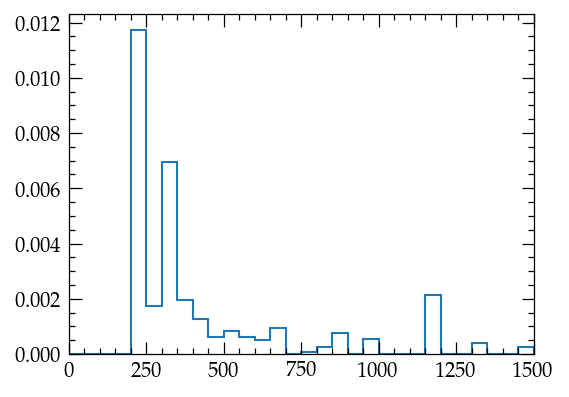

In [27]:
qcd = mc.loc[("central", "METnoX_pt", "Monojet", "QCD"),"sum_w"]
sm = mc.loc[("central", "METnoX_pt", "Monojet"),"sum_w"].groupby("binvar0").sum()

binning = np.linspace(0., 1500., 31)
qcd = dftools.transform.rebin(qcd, binning)
sm = dftools.transform.rebin(sm, binning)

fig, ax = plt.subplots()

ax.hist(
    binning, bins=binning,
    weights=(qcd/sm)["sum_w"].fillna(0.),
    histtype='step',
    color='#1f78b4',
)
ax.set_xlim(binning[0], binning[-1])
ax.set_ylim(0., None)

(0.0, 0.04764129413923437)

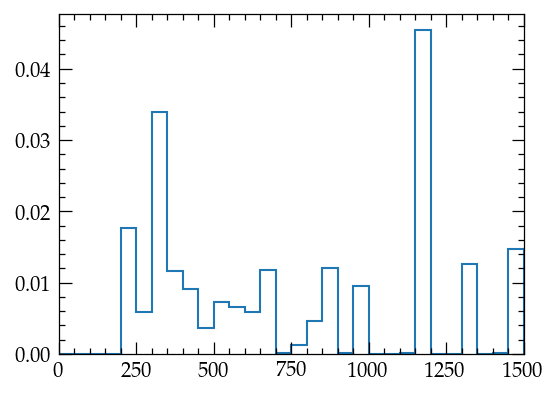

In [31]:
qcd = mc.loc[("central", "METnoX_pt", "Monojet", "QCD"),"sum_w"]
qcd_qcd = mc.loc[("central", "METnoX_pt", "MonojetQCD", "QCD"),"sum_w"]

binning = np.linspace(0., 1500., 31)
qcd = dftools.transform.rebin(qcd, binning)
qcd_qcd = dftools.transform.rebin(qcd_qcd, binning)

fig, ax = plt.subplots()

ax.hist(
    binning, bins=binning,
    weights=(qcd/qcd_qcd)["sum_w"].fillna(0.),
    histtype='step',
    color='#1f78b4',
)
ax.set_xlim(binning[0], binning[-1])
ax.set_ylim(0., None)

## Single Muon control region

In [8]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "Top": ["SingleTop", "TTJets"],
    "Minor": [
        "ZJetsToNuNu", "DYJetsToTauHTauH", "DYJetsToEE", "WJetsToENu", "WJetsToTauHNu", "VGamma", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "G1Jet",
        "EWKV2Jets",
    ],
})

In [9]:
data_met = data.loc[("central", "METnoX_pt", "SingleMuon", "MET")]
mc_met = mc.loc[("central", "METnoX_pt", "SingleMuon")]
met_binning = np.linspace(0., 1600., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_mupt = data.loc[("central", "LeadMuonSelection_pt", "SingleMuon", "MET")]
mc_mupt = mc.loc[("central", "LeadMuonSelection_pt", "SingleMuon")]
mupt_binning = np.linspace(0., 800., 21)
data_mupt = dftools.transform.rebin(data_mupt, mupt_binning)
mc_mupt = dftools.transform.rebin(mc_mupt, mupt_binning)

data_mueta = data.loc[("central", "LeadMuonSelection_eta", "SingleMuon", "MET")]
mc_mueta = mc.loc[("central", "LeadMuonSelection_eta", "SingleMuon")]
mueta_binning = np.linspace(-2.81, 2.8, 15)
data_mueta = dftools.transform.rebin(data_mueta, mueta_binning)
mc_mueta = dftools.transform.rebin(mc_mueta, mueta_binning)

data_mtw = data.loc[("central", "MTW", "SingleMuon", "MET")]
mc_mtw = mc.loc[("central", "MTW", "SingleMuon")]
mtw_binning = np.linspace(0., 160., 21)
data_mtw = dftools.transform.rebin(data_mtw, mtw_binning)
mc_mtw = dftools.transform.rebin(mc_mtw, mtw_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "SingleMuon", "MET")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "SingleMuon")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)


In [10]:
help(dftools.draw.data_mc)

Help on function data_mc in module dftools.draw:

data_mc(ax, df_data, df_mc, label, bins, blind=False, log=True, legend=True, ratio=True, sm_total=True, mcstat_top=False, add_ratios=True, mc_kw={}, mcstat_kw={}, sm_kw={}, data_kw={}, proc_kw={}, legend_kw={}, cms_kw={})



/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa85bc249b0>,
      dtype=object)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


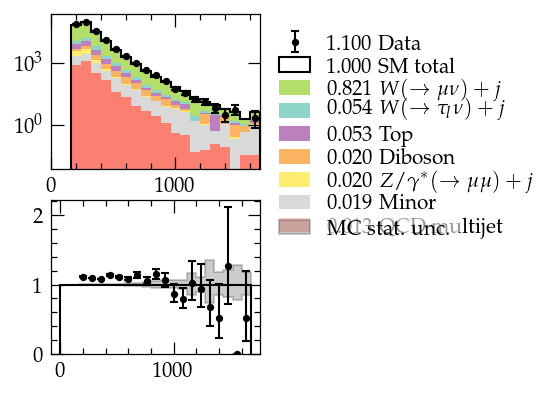

In [11]:
fig, ax = plt.subplots(
    figsize=(2.25, 3), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


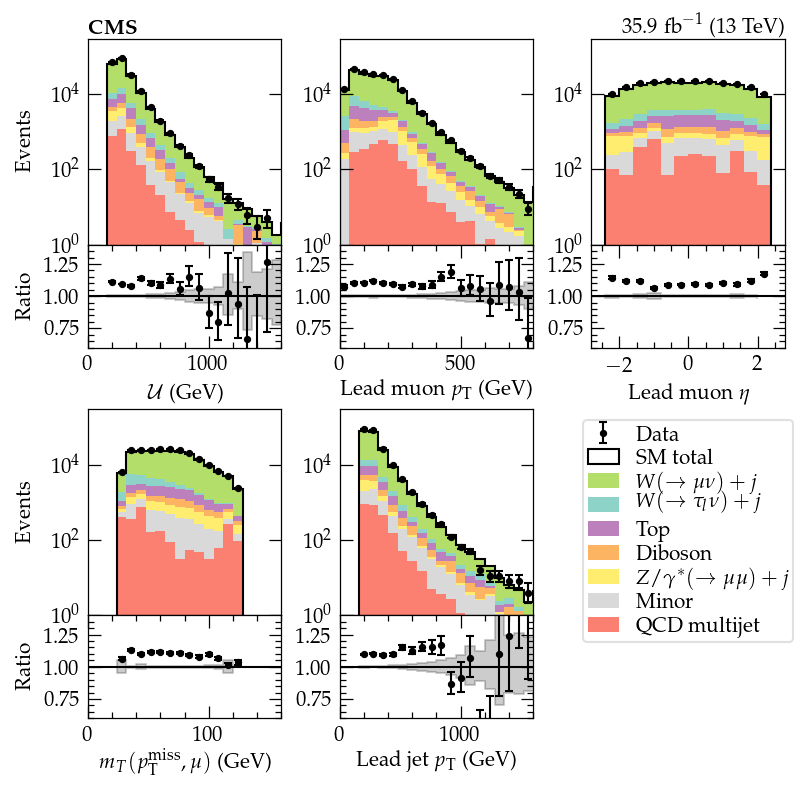

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0), (1,1)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 2])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_mupt, mc_mupt, "binvar0", mupt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_mueta, mc_mueta, "binvar0", mueta_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_mtw, mc_mtw, "binvar0", mtw_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[4], ax_ratio[4]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(mupt_binning[0], mupt_binning[-1])
ax_dist[2].set_xlim(mueta_binning[0], mueta_binning[-1])
ax_dist[3].set_xlim(mtw_binning[0], mtw_binning[-1])
ax_dist[4].set_xlim(jpt_binning[0], jpt_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(mupt_binning[0], mupt_binning[-1])
ax_ratio[2].set_xlim(mueta_binning[0], mueta_binning[-1])
ax_ratio[3].set_xlim(mtw_binning[0], mtw_binning[-1])
ax_ratio[4].set_xlim(jpt_binning[0], jpt_binning[-1])

ax_dist[0].set_ylim(1, 3e5)
ax_dist[1].set_ylim(1, 3e5)
ax_dist[2].set_ylim(1, 3e5)
ax_dist[3].set_ylim(1, 3e5)
ax_dist[4].set_ylim(1, 3e5)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)
ax_dist[4].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.6, 1.4)
ax_ratio[1].set_ylim(0.6, 1.4)
ax_ratio[2].set_ylim(0.6, 1.4)
ax_ratio[3].set_ylim(0.6, 1.4)
ax_ratio[4].set_ylim(0.6, 1.4)
#fig.align_labels(ax)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead muon $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'Lead muon $\eta$')
ax_ratio[3].set_xlabel(r'$m_{T}(p_{\mathrm{T}}^{\mathrm{miss}},\mu)$ (GeV)')
ax_ratio[4].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/singlemuon_dists.pdf")
pass

## Single Electron control region

In [13]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "Top": ["SingleTop", "TTJets"],
    "Minor": [
        "DYJetsToMuMu", "WJetsToMuNu",
        "DYJetsToTauHTauH", "ZJetsToNuNu", "VGamma", "DYJetsToEE",
        "WJetsToTauHNu", "G1Jet", "DYJetsToTauHTauL", "DYJetsToTauLTauL",
        "QCD", "EWKV2Jets", "Diboson",
    ],
})

In [14]:
data_met = data.loc[("central", "METnoX_pt", "SingleElectron", "SingleElectron")]
mc_met = mc.loc[("central", "METnoX_pt", "SingleElectron")]
met_binning = np.linspace(0., 1600., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_ept = data.loc[("central", "LeadElectronSelection_pt", "SingleElectron", "SingleElectron")]
mc_ept = mc.loc[("central", "LeadElectronSelection_pt", "SingleElectron")]
ept_binning = np.linspace(0., 800., 21)
data_ept = dftools.transform.rebin(data_ept, ept_binning)
mc_ept = dftools.transform.rebin(mc_ept, ept_binning)

data_eeta = data.loc[("central", "LeadElectronSelection_eta", "SingleElectron", "SingleElectron")]
mc_eeta = mc.loc[("central", "LeadElectronSelection_eta", "SingleElectron")]
eeta_binning = np.linspace(-2.81, 2.8, 15)
data_eeta = dftools.transform.rebin(data_eeta, eeta_binning)
mc_eeta = dftools.transform.rebin(mc_eeta, eeta_binning)

data_mtw = data.loc[("central", "MTW", "SingleElectron", "SingleElectron")]
mc_mtw = mc.loc[("central", "MTW", "SingleElectron")]
mtw_binning = np.linspace(0., 160., 21)
data_mtw = dftools.transform.rebin(data_mtw, mtw_binning)
mc_mtw = dftools.transform.rebin(mc_mtw, mtw_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "SingleElectron", "SingleElectron")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "SingleElectron")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


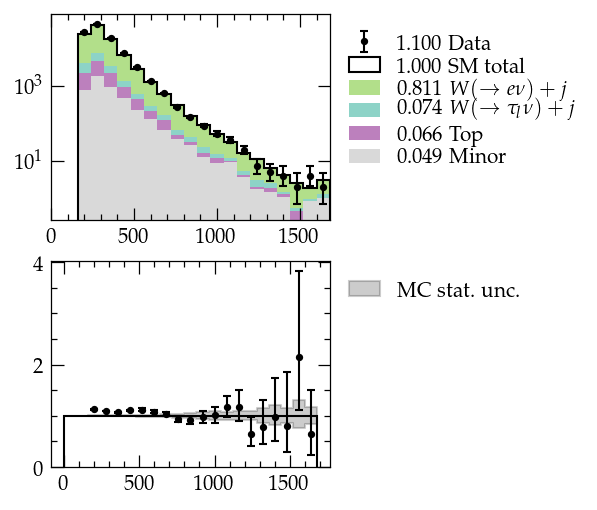

In [15]:
fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)
pass

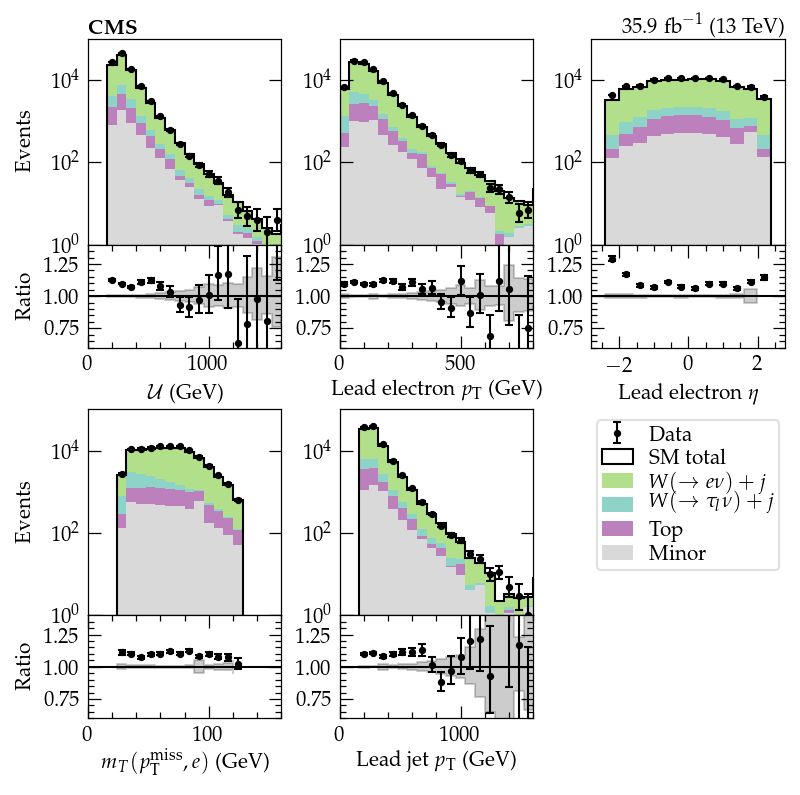

In [16]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0), (1,1)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 2])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_ept, mc_ept, "binvar0", ept_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_eeta, mc_eeta, "binvar0", eeta_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_mtw, mc_mtw, "binvar0", mtw_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[4], ax_ratio[4]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(ept_binning[0], ept_binning[-1])
ax_dist[2].set_xlim(eeta_binning[0], eeta_binning[-1])
ax_dist[3].set_xlim(mtw_binning[0], mtw_binning[-1])
ax_dist[4].set_xlim(jpt_binning[0], jpt_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(ept_binning[0], ept_binning[-1])
ax_ratio[2].set_xlim(eeta_binning[0], eeta_binning[-1])
ax_ratio[3].set_xlim(mtw_binning[0], mtw_binning[-1])
ax_ratio[4].set_xlim(jpt_binning[0], jpt_binning[-1])

ax_dist[0].set_ylim(1, 1e5)
ax_dist[1].set_ylim(1, 1e5)
ax_dist[2].set_ylim(1, 1e5)
ax_dist[3].set_ylim(1, 1e5)
ax_dist[4].set_ylim(1, 1e5)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)
ax_dist[4].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.6, 1.4)
ax_ratio[1].set_ylim(0.6, 1.4)
ax_ratio[2].set_ylim(0.6, 1.4)
ax_ratio[3].set_ylim(0.6, 1.4)
ax_ratio[4].set_ylim(0.6, 1.4)
#fig.align_labels(ax)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead electron $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'Lead electron $\eta$')
ax_ratio[3].set_xlabel(r'$m_{T}(p_{\mathrm{T}}^{\mathrm{miss}},e)$ (GeV)')
ax_ratio[4].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/singleele_dists.pdf")
pass

## Single Tau control region

In [17]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "WJetsToTauNu": ["WJetsToTauLNu", "WJetsToTauHNu"],
    "Top": ["SingleTop", "TTJets"],
    "Minor": [
        "DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauLTauL",
        "DYJetsToTauHTauL", "DYJetsToTauHTauH",
        "G1Jet", "VGamma", "WJetsToMuNu",
        "ZJetsToNuNu",
    ],
})

In [18]:
data_met = data.loc[("central", "METnoX_pt", "SingleTau", "MET")]
mc_met = mc.loc[("central", "METnoX_pt", "SingleTau")]
met_binning = np.linspace(0., 1600., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_ept = data.loc[("central", "LeadTauSelection_pt", "SingleTau", "MET")]
mc_ept = mc.loc[("central", "LeadTauSelection_pt", "SingleTau")]
ept_binning = np.linspace(0., 800., 21)
data_ept = dftools.transform.rebin(data_ept, ept_binning)
mc_ept = dftools.transform.rebin(mc_ept, ept_binning)

data_eeta = data.loc[("central", "LeadTauSelection_eta", "SingleTau", "MET")]
mc_eeta = mc.loc[("central", "LeadTauSelection_eta", "SingleTau")]
eeta_binning = np.linspace(-2.81, 2.8, 15)
data_eeta = dftools.transform.rebin(data_eeta, eeta_binning)
mc_eeta = dftools.transform.rebin(mc_eeta, eeta_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "SingleTau", "MET")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "SingleTau")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)


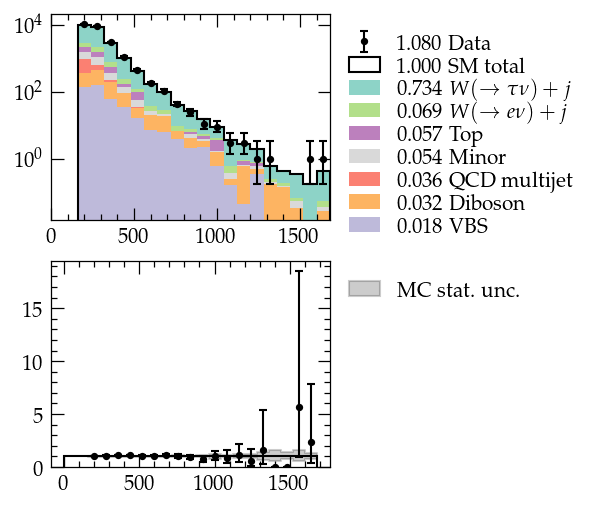

In [19]:
fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)
pass

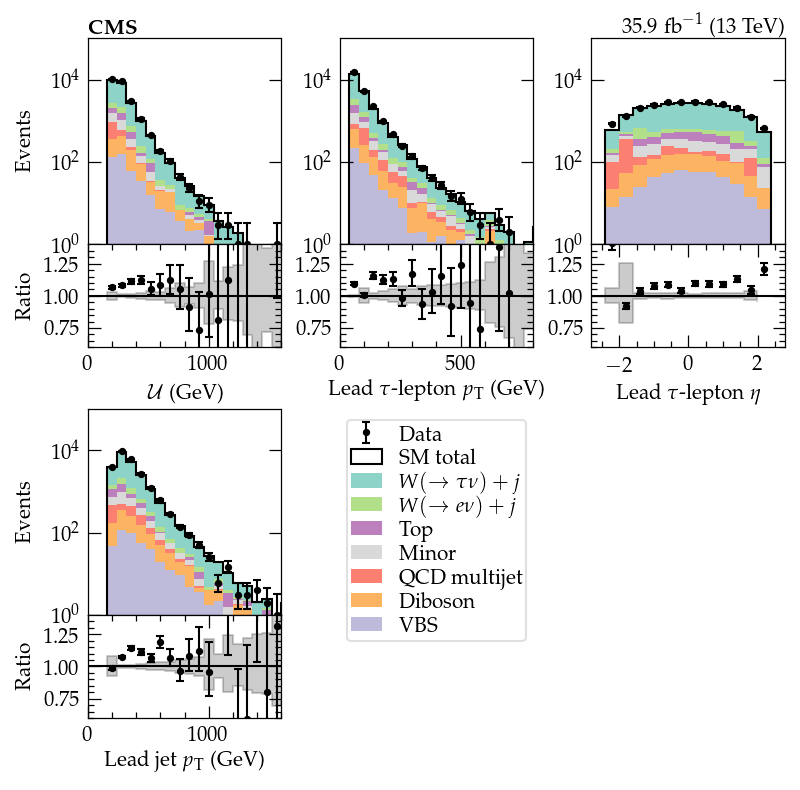

In [20]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 1])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_ept, mc_ept, "binvar0", ept_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_eeta, mc_eeta, "binvar0", eeta_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(ept_binning[0], ept_binning[-1])
ax_dist[2].set_xlim(eeta_binning[0], eeta_binning[-1])
ax_dist[3].set_xlim(jpt_binning[0], jpt_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(ept_binning[0], ept_binning[-1])
ax_ratio[2].set_xlim(eeta_binning[0], eeta_binning[-1])
ax_ratio[3].set_xlim(jpt_binning[0], jpt_binning[-1])

ax_dist[0].set_ylim(1, 1e5)
ax_dist[1].set_ylim(1, 1e5)
ax_dist[2].set_ylim(1, 1e5)
ax_dist[3].set_ylim(1, 1e5)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.6, 1.4)
ax_ratio[1].set_ylim(0.6, 1.4)
ax_ratio[2].set_ylim(0.6, 1.4)
ax_ratio[3].set_ylim(0.6, 1.4)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead $\tau$-lepton $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'Lead $\tau$-lepton $\eta$')
ax_ratio[3].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/singletau_dists.pdf")
pass

## Monojet control region

In [32]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    #"WJetsToTauNu": ["WJetsToTauLNu", "WJetsToTauHNu"],
    "Top": ["SingleTop", "TTJets"],
    "Minor": [
        "DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauLTauL",
        "DYJetsToTauHTauL", "DYJetsToTauHTauH",
        "G1Jet", "VGamma", "EWKV2Jets", "Diboson",
    ],
})

In [33]:
data_met = data.loc[("central", "METnoX_pt", "Monojet", "MET")]
mc_met = mc.loc[("central", "METnoX_pt", "Monojet")]
met_binning = np.linspace(0., 1600., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "Monojet", "MET")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "Monojet")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)

data_jeta = data.loc[("central", "LeadJetSelection_eta", "Monojet", "MET")]
mc_jeta = mc.loc[("central", "LeadJetSelection_eta", "Monojet")]
jeta_binning = np.linspace(-2.81, 2.8, 15)
data_jeta = dftools.transform.rebin(data_jeta, jeta_binning)
mc_jeta = dftools.transform.rebin(mc_jeta, jeta_binning)

data_dphi = data.loc[("central", "MinDPhiJ1234METnoX", "Monojet", "MET")]
mc_dphi = mc.loc[("central", "MinDPhiJ1234METnoX", "Monojet")]
dphi_binning = np.linspace(0., 4., 21)
data_dphi = dftools.transform.rebin(data_dphi, dphi_binning)
mc_dphi = dftools.transform.rebin(mc_dphi, dphi_binning)

data_nj = data.loc[("central", "nJetSelection", "Monojet", "MET")]
mc_nj = mc.loc[("central", "nJetSelection", "Monojet")]
nj_binning = np.linspace(0., 20., 21)
data_nj = dftools.transform.rebin(data_nj, nj_binning)
mc_nj = dftools.transform.rebin(mc_nj, nj_binning)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


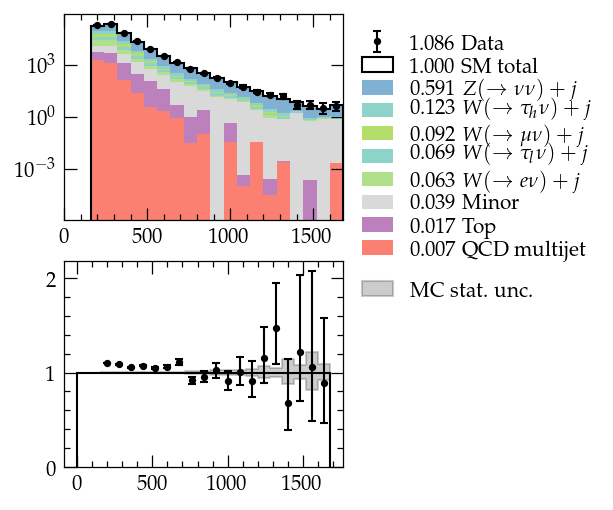

In [34]:
fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)
pass

## Monojet QCD control region

In [128]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "WJetsToLNu": ["WJetsToENu", "WJetsToMuNu", "WJetsToTauLNu", "WJetsToTauHNu"],
    "Top": ["SingleTop", "TTJets"],
    "Minor": [
        "DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "DYJetsToTauHTauH",
        "VGamma", "G1Jet", "Diboson", "EWKV2Jets",
    ],
})

In [129]:
data_met = data.loc[("central", "METnoX_pt", "MonojetQCD", "MET")]
mc_met = mc.loc[("central", "METnoX_pt", "MonojetQCD")]
met_binning = np.linspace(0., 1200., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "MonojetQCD", "MET")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "MonojetQCD")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)

data_jeta = data.loc[("central", "LeadJetSelection_eta", "MonojetQCD", "MET")]
mc_jeta = mc.loc[("central", "LeadJetSelection_eta", "MonojetQCD")]
jeta_binning = np.linspace(-2.81, 2.8, 15)
data_jeta = dftools.transform.rebin(data_jeta, jeta_binning)
mc_jeta = dftools.transform.rebin(mc_jeta, jeta_binning)

data_dphi = data.loc[("central", "MinDPhiJ1234METnoX", "MonojetQCD", "MET")]
mc_dphi = mc.loc[("central", "MinDPhiJ1234METnoX", "MonojetQCD")]
dphi_binning = np.linspace(0., 1., 21)
data_dphi = dftools.transform.rebin(data_dphi, dphi_binning)
mc_dphi = dftools.transform.rebin(mc_dphi, dphi_binning)

data_nj = data.loc[("central", "nJetSelection", "MonojetQCD", "MET")]
mc_nj = mc.loc[("central", "nJetSelection", "MonojetQCD")]
nj_binning = np.linspace(0., 20., 21)
data_nj = dftools.transform.rebin(data_nj, nj_binning)
mc_nj = dftools.transform.rebin(mc_nj, nj_binning)

njpt_binning = np.array([0.]+list(np.linspace(0., 1600., 21)+40.))
data_njpt = data.loc[("central", "NearestJetSelectionMET_pt", "MonojetQCD", "MET")]
mc_njpt = mc.loc[("central", "NearestJetSelectionMET_pt", "MonojetQCD")]
data_njpt = dftools.transform.rebin(data_njpt, njpt_binning)
mc_njpt = dftools.transform.rebin(mc_njpt, njpt_binning)

data_njeta = data.loc[("central", "NearestJetSelectionMET_eta", "MonojetQCD", "MET")]
mc_njeta = mc.loc[("central", "NearestJetSelectionMET_eta", "MonojetQCD")]
njeta_binning = np.linspace(-2.81, 2.8, 15)
data_njeta = dftools.transform.rebin(data_njeta, njeta_binning)
mc_njeta = dftools.transform.rebin(mc_njeta, njeta_binning)

In [130]:
data_dphi.loc[data_dphi.index.get_level_values("binvar0")>=0.5, "sum_w"]=0.
data_dphi.loc[data_dphi.index.get_level_values("binvar0")>=0.5, "sum_ww"]=0.
mc_dphi.loc[mc_dphi.index.get_level_values("binvar0")>=0.5, "sum_w"]=0.
mc_dphi.loc[mc_dphi.index.get_level_values("binvar0")>=0.5, "sum_ww"]=0.

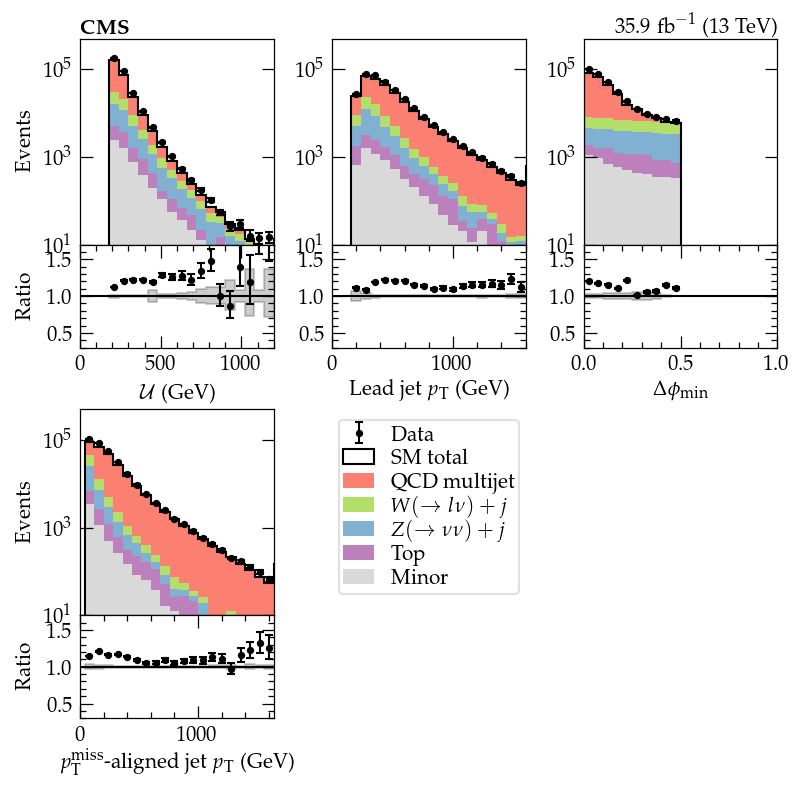

In [132]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 1])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_dphi, mc_dphi, "binvar0", dphi_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_njpt, mc_njpt, "binvar0", njpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_dist[2].set_xlim(dphi_binning[0], dphi_binning[-1])
ax_dist[3].set_xlim(njpt_binning[0], njpt_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_ratio[2].set_xlim(dphi_binning[0], dphi_binning[-1])
ax_ratio[3].set_xlim(njpt_binning[0], njpt_binning[-1])

ax_dist[0].set_ylim(1e1, 5e5)
ax_dist[1].set_ylim(1e1, 5e5)
ax_dist[2].set_ylim(1e1, 5e5)
ax_dist[3].set_ylim(1e1, 5e5)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.3, 1.7)
ax_ratio[1].set_ylim(0.3, 1.7)
ax_ratio[2].set_ylim(0.3, 1.7)
ax_ratio[3].set_ylim(0.3, 1.7)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'$\Delta \phi_{\mathrm{min}}$')
ax_ratio[3].set_xlabel(r'$p_{\mathrm{T}}^{\mathrm{miss}}$-aligned jet $p_{\mathrm{T}}$ (GeV)')

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/monojetqcd_dists.pdf")
pass

## Monojet

In [135]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "WJetsToLNu": ["WJetsToENu", "WJetsToMuNu", "WJetsToTauLNu", "WJetsToTauHNu"],
    "Top": ["SingleTop", "TTJets"],
    "Minor": [
        "DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "DYJetsToTauHTauH",
        "VGamma", "G1Jet", "Diboson", "EWKV2Jets",
    ],
})

In [136]:
data_met = data.loc[("central", "METnoX_pt", "Monojet", "MET")]
mc_met = mc.loc[("central", "METnoX_pt", "Monojet")]
met_binning = np.linspace(0., 1200., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "Monojet", "MET")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "Monojet")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)

data_jeta = data.loc[("central", "LeadJetSelection_eta", "Monojet", "MET")]
mc_jeta = mc.loc[("central", "LeadJetSelection_eta", "Monojet")]
jeta_binning = np.linspace(-2.81, 2.8, 15)
data_jeta = dftools.transform.rebin(data_jeta, jeta_binning)
mc_jeta = dftools.transform.rebin(mc_jeta, jeta_binning)

data_dphi = data.loc[("central", "MinDPhiJ1234METnoX", "Monojet", "MET")]
mc_dphi = mc.loc[("central", "MinDPhiJ1234METnoX", "Monojet")]
dphi_binning = np.linspace(0., np.pi, 21)
data_dphi = dftools.transform.rebin(data_dphi, dphi_binning)
mc_dphi = dftools.transform.rebin(mc_dphi, dphi_binning)

data_nj = data.loc[("central", "nJetSelection", "Monojet", "MET")]
mc_nj = mc.loc[("central", "nJetSelection", "Monojet")]
nj_binning = np.linspace(0., 20., 21)
data_nj = dftools.transform.rebin(data_nj, nj_binning)
mc_nj = dftools.transform.rebin(mc_nj, nj_binning)

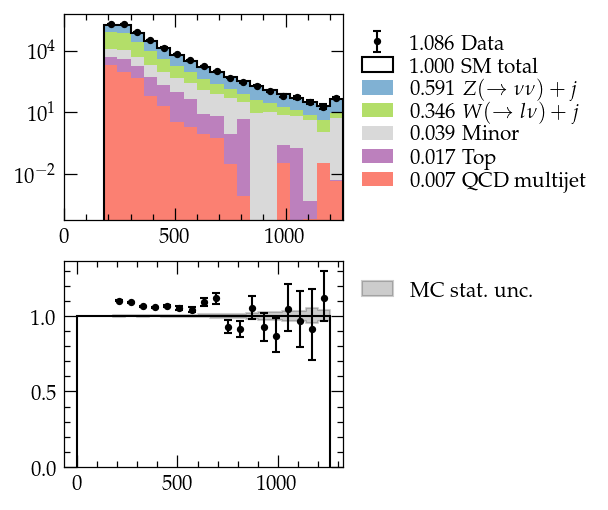

In [137]:
fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)
pass

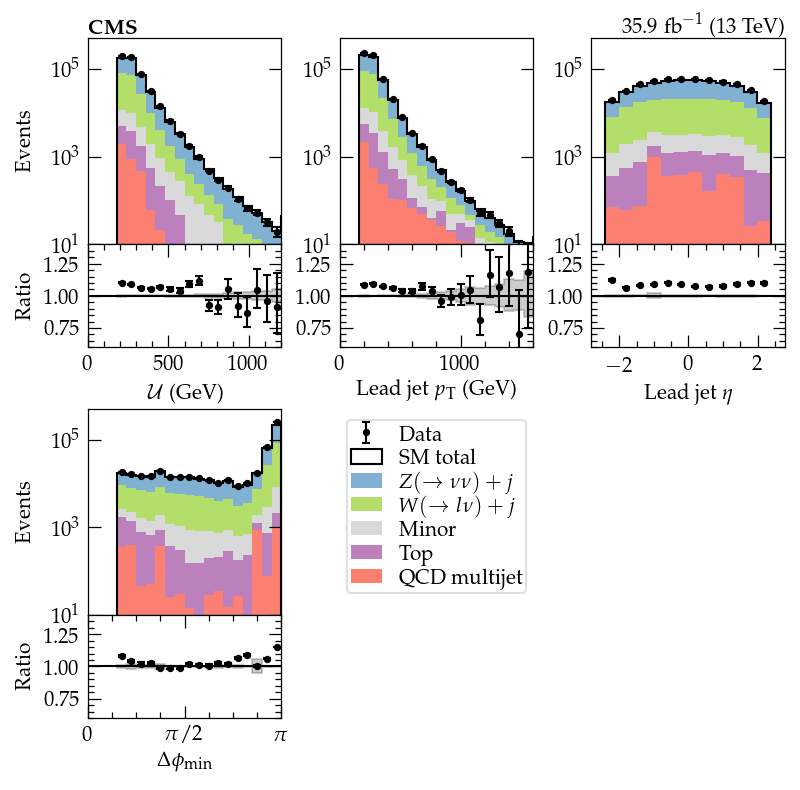

In [127]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 1])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_jeta, mc_jeta, "binvar0", jeta_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_dphi, mc_dphi, "binvar0", dphi_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_dist[2].set_xlim(jeta_binning[0], jeta_binning[-1])
ax_dist[3].set_xlim(dphi_binning[0], dphi_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_ratio[2].set_xlim(jeta_binning[0], jeta_binning[-1])
ax_ratio[3].set_xlim(dphi_binning[0], dphi_binning[-1])

ax_dist[0].set_ylim(1e1, 5e5)
ax_dist[1].set_ylim(1e1, 5e5)
ax_dist[2].set_ylim(1e1, 5e5)
ax_dist[3].set_ylim(1e1, 5e5)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.6, 1.4)
ax_ratio[1].set_ylim(0.6, 1.4)
ax_ratio[2].set_ylim(0.6, 1.4)
ax_ratio[3].set_ylim(0.6, 1.4)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'Lead jet $\eta$')
ax_ratio[3].set_xlabel(r'$\Delta \phi_{\mathrm{min}}$')
ax_ratio[3].set_xticks([0., np.pi/2., np.pi])
ax_ratio[3].set_xticklabels(["$0$", r'$\pi/2$', r'$\pi$'])

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/monojet_dists.pdf")
pass

## DoubleMuon

In [139]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "Diboson": ["VGamma", "Diboson"],
    "Minor": [
        "DYJetsToEE", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "DYJetsToTauHTauH",
        "WJetsToENu", "WJetsToMuNu", "WJetsToTauLNu", "WJetsToTauHNu",
        "SingleTop", "TTJets",
        "G1Jet", "EWKV2Jets",
    ],
})

In [140]:
data_met = data.loc[("central", "METnoX_pt", "DoubleMuon", "MET")]
mc_met = mc.loc[("central", "METnoX_pt", "DoubleMuon")]
met_binning = np.linspace(0., 1200., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "DoubleMuon", "MET")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "DoubleMuon")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)

data_mupt = data.loc[("central", "LeadMuonSelection_pt", "DoubleMuon", "MET")]
mc_mupt = mc.loc[("central", "LeadMuonSelection_pt", "DoubleMuon")]
mupt_binning = np.linspace(0., 800., 21)
data_mupt = dftools.transform.rebin(data_mupt, mupt_binning)
mc_mupt = dftools.transform.rebin(mc_mupt, mupt_binning)

data_mupt2 = data.loc[("central", "SecondMuonSelection_pt", "DoubleMuon", "MET")]
mc_mupt2 = mc.loc[("central", "SecondMuonSelection_pt", "DoubleMuon")]
mupt2_binning = np.linspace(0., 400., 21)
data_mupt2 = dftools.transform.rebin(data_mupt2, mupt2_binning)
mc_mupt2 = dftools.transform.rebin(mc_mupt2, mupt2_binning)

data_mll = data.loc[("central", "MLL", "DoubleMuon", "MET")]
mc_mll = mc.loc[("central", "MLL", "DoubleMuon")]
mll_binning = np.linspace(71., 111., 21)
data_mll = dftools.transform.rebin(data_mll, mll_binning)
mc_mll = dftools.transform.rebin(mc_mll, mll_binning)

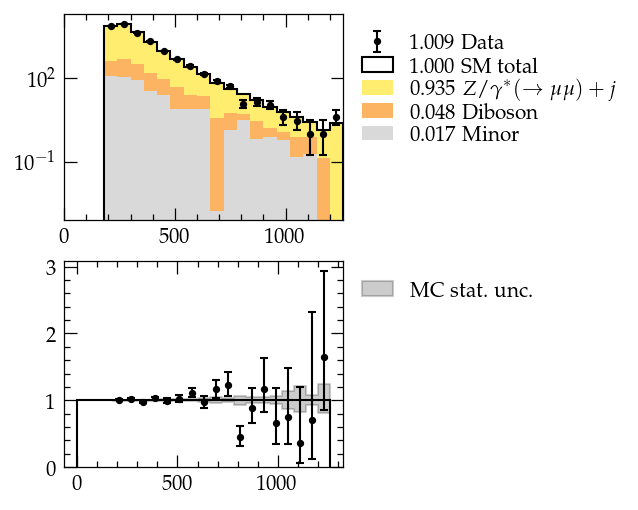

In [141]:
fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


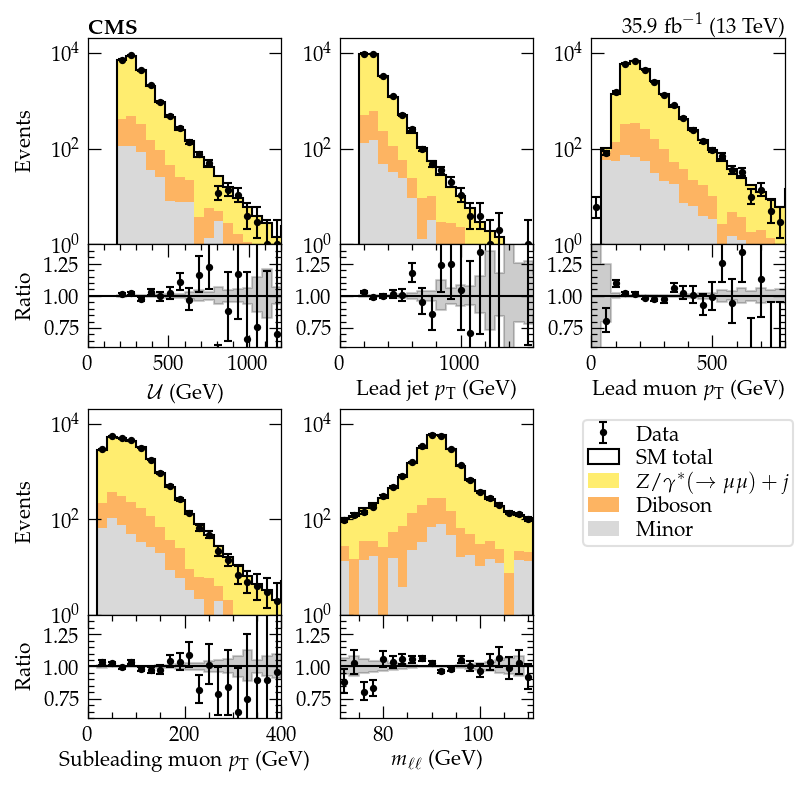

In [113]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0), (1,1)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 2])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_mupt, mc_mupt, "binvar0", mupt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_mupt2, mc_mupt2, "binvar0", mupt2_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[4], ax_ratio[4]), data_mll, mc_mll, "binvar0", mll_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_dist[2].set_xlim(mupt_binning[0], mupt_binning[-1])
ax_dist[3].set_xlim(mupt2_binning[0], mupt2_binning[-1])
ax_dist[4].set_xlim(mll_binning[0], mll_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_ratio[2].set_xlim(mupt_binning[0], mupt_binning[-1])
ax_ratio[3].set_xlim(mupt2_binning[0], mupt2_binning[-1])
ax_ratio[4].set_xlim(mll_binning[0], mll_binning[-1])

ax_dist[0].set_ylim(1, 2e4)
ax_dist[1].set_ylim(1, 2e4)
ax_dist[2].set_ylim(1, 2e4)
ax_dist[3].set_ylim(1, 2e4)
ax_dist[4].set_ylim(1, 2e4)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)
ax_dist[4].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.6, 1.4)
ax_ratio[1].set_ylim(0.6, 1.4)
ax_ratio[2].set_ylim(0.6, 1.4)
ax_ratio[3].set_ylim(0.6, 1.4)
ax_ratio[4].set_ylim(0.6, 1.4)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'Lead muon $p_{\mathrm{T}}$ (GeV)')
ax_ratio[3].set_xlabel(r'Subleading muon $p_{\mathrm{T}}$ (GeV)')
ax_ratio[4].set_xlabel(r'$m_{\ell\ell}$ (GeV)')

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/doublemuon_dists.pdf")
pass

## DoubleElectron

In [142]:
data = pd.read_hdf("data/dists_fixtau.h5", "DataAggEvents")
mc = pd.read_hdf("data/dists_fixtau.h5", "MCAggEvents")
mc = dftools.transform.merge(mc, {
    "Diboson": ["Diboson", "VGamma"],
    "Minor": [
        "WJetsToENu", "WJetsToMuNu", "WJetsToTauLNu", "WJetsToTauHNu",
        "DYJetsToMuMu", "DYJetsToTauLTauL", "DYJetsToTauHTauL", "DYJetsToTauHTauH",
        "G1Jet", "EWKV2Jets", "SingleTop", "TTJets",
    ],
})

In [143]:
data_met = data.loc[("central", "METnoX_pt", "DoubleElectron", "SingleElectron")]
mc_met = mc.loc[("central", "METnoX_pt", "DoubleElectron")]
met_binning = np.linspace(0., 1200., 21)
data_met = dftools.transform.rebin(data_met, met_binning)
mc_met = dftools.transform.rebin(mc_met, met_binning)

data_jpt = data.loc[("central", "LeadJetSelection_pt", "DoubleElectron", "SingleElectron")]
mc_jpt = mc.loc[("central", "LeadJetSelection_pt", "DoubleElectron")]
jpt_binning = np.linspace(0., 1600., 21)
data_jpt = dftools.transform.rebin(data_jpt, jpt_binning)
mc_jpt = dftools.transform.rebin(mc_jpt, jpt_binning)

data_mupt = data.loc[("central", "LeadElectronSelection_pt", "DoubleElectron", "SingleElectron")]
mc_mupt = mc.loc[("central", "LeadElectronSelection_pt", "DoubleElectron")]
mupt_binning = np.linspace(0., 800., 21)
data_mupt = dftools.transform.rebin(data_mupt, mupt_binning)
mc_mupt = dftools.transform.rebin(mc_mupt, mupt_binning)

data_mupt2 = data.loc[("central", "SecondElectronSelection_pt", "DoubleElectron", "SingleElectron")]
mc_mupt2 = mc.loc[("central", "SecondElectronSelection_pt", "DoubleElectron")]
mupt2_binning = np.linspace(0., 400., 21)
data_mupt2 = dftools.transform.rebin(data_mupt2, mupt2_binning)
mc_mupt2 = dftools.transform.rebin(mc_mupt2, mupt2_binning)

data_mll = data.loc[("central", "MLL", "DoubleElectron", "SingleElectron")]
mc_mll = mc.loc[("central", "MLL", "DoubleElectron")]
mll_binning = np.linspace(71., 111., 21)
data_mll = dftools.transform.rebin(data_mll, mll_binning)
mc_mll = dftools.transform.rebin(mc_mll, mll_binning)

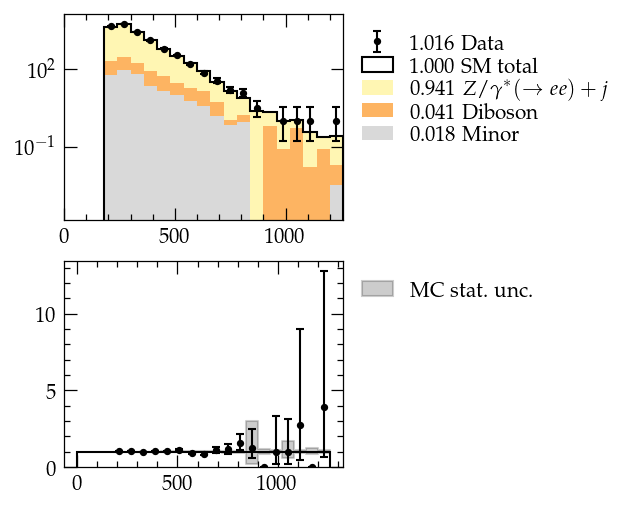

In [144]:
fig, ax = plt.subplots(
    figsize=(3, 4), dpi=150,
    nrows=2,
)

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    ax, data_met, mc_met, "binvar0", met_binning,
    proc_kw={"colours": colours, "labels": labels},
)
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


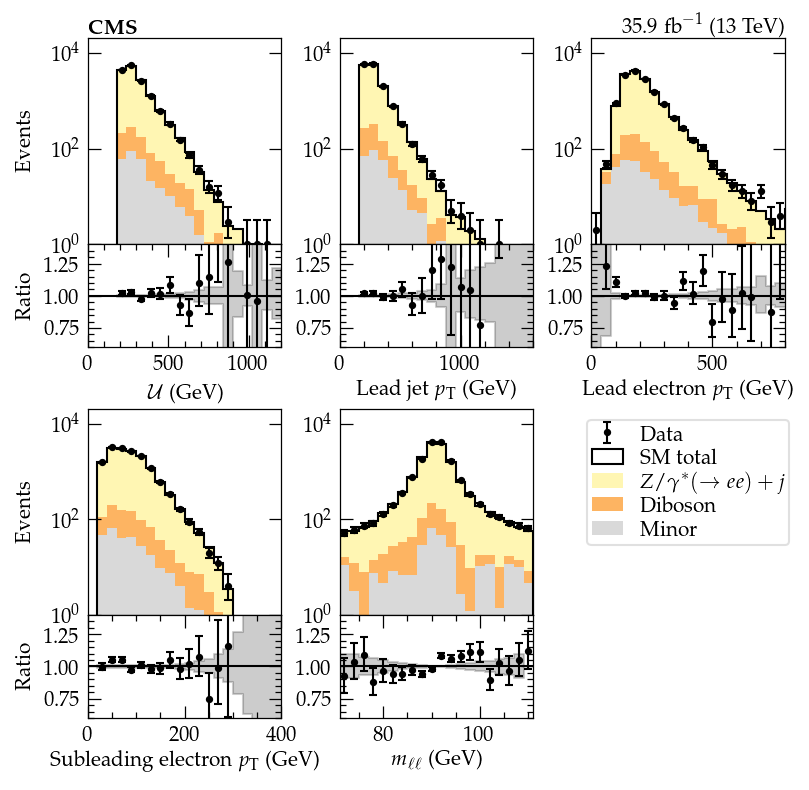

In [123]:
import matplotlib.gridspec as gridspec

fig = plt.figure(
    figsize=(6,6), dpi=150,
)

grid = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.2)

ax_dist = []
ax_ratio = []
for i, j in ((0,0), (0,1), (0,2), (1,0), (1,1)):
    subg = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=grid[i,j], hspace=0.,
        height_ratios=(2,1),
    )
    ax_dist.append(fig.add_subplot(subg[0]))
    ax_ratio.append(fig.add_subplot(subg[1]))
ax_leg = fig.add_subplot(grid[1, 2])
ax_leg.axis('off')

colours = dftools.draw.process_colours
labels = dftools.draw.process_names
labels["Minor"] = "Minor"
dftools.draw.data_mc(
    (ax_dist[0], ax_ratio[0]), data_met, mc_met, "binvar0", met_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[1], ax_ratio[1]), data_jpt, mc_jpt, "binvar0", jpt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[2], ax_ratio[2]), data_mupt, mc_mupt, "binvar0", mupt_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[3], ax_ratio[3]), data_mupt2, mc_mupt2, "binvar0", mupt2_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)
dftools.draw.data_mc(
    (ax_dist[4], ax_ratio[4]), data_mll, mc_mll, "binvar0", mll_binning, legend=False,
    proc_kw={"colours": colours, "labels": labels},
)

ax_dist[0].set_xlim(met_binning[0], met_binning[-1])
ax_dist[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_dist[2].set_xlim(mupt_binning[0], mupt_binning[-1])
ax_dist[3].set_xlim(mupt2_binning[0], mupt2_binning[-1])
ax_dist[4].set_xlim(mll_binning[0], mll_binning[-1])
 
ax_ratio[0].set_xlim(met_binning[0], met_binning[-1])
ax_ratio[1].set_xlim(jpt_binning[0], jpt_binning[-1])
ax_ratio[2].set_xlim(mupt_binning[0], mupt_binning[-1])
ax_ratio[3].set_xlim(mupt2_binning[0], mupt2_binning[-1])
ax_ratio[4].set_xlim(mll_binning[0], mll_binning[-1])

ax_dist[0].set_ylim(1, 2e4)
ax_dist[1].set_ylim(1, 2e4)
ax_dist[2].set_ylim(1, 2e4)
ax_dist[3].set_ylim(1, 2e4)
ax_dist[4].set_ylim(1, 2e4)

ax_dist[0].get_xaxis().set_visible(False)
ax_dist[1].get_xaxis().set_visible(False)
ax_dist[2].get_xaxis().set_visible(False)
ax_dist[3].get_xaxis().set_visible(False)
ax_dist[4].get_xaxis().set_visible(False)

ax_ratio[0].set_ylim(0.6, 1.4)
ax_ratio[1].set_ylim(0.6, 1.4)
ax_ratio[2].set_ylim(0.6, 1.4)
ax_ratio[3].set_ylim(0.6, 1.4)
ax_ratio[4].set_ylim(0.6, 1.4)

ax_ratio[0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax_ratio[1].set_xlabel(r'Lead jet $p_{\mathrm{T}}$ (GeV)')
ax_ratio[2].set_xlabel(r'Lead electron $p_{\mathrm{T}}$ (GeV)')
ax_ratio[3].set_xlabel(r'Subleading electron $p_{\mathrm{T}}$ (GeV)')
ax_ratio[4].set_xlabel(r'$m_{\ell\ell}$ (GeV)')

ax_dist[0].set_ylabel(r'Events')
ax_ratio[0].set_ylabel(r'Ratio')
ax_dist[3].set_ylabel(r'Events')
ax_ratio[3].set_ylabel(r'Ratio')

handles, labels = ax_dist[0].get_legend_handles_labels()
ax_leg.legend(
    handles[::-1], labels[::-1],
    loc=9, bbox_to_anchor=(0.5, 1),
    labelspacing=0.1, borderpad=0.2,
    frameon=True, framealpha=0.8, fancybox=True,
    edgecolor='#d9d9d9',
)

fig.align_ylabels((ax_dist[0], ax_ratio[0], ax_dist[3], ax_ratio[3]))

ax_dist[0].text(
    0, 1, '$\mathbf{CMS}$',
    transform=ax_dist[0].transAxes,
    ha='left', va='bottom',
)
ax_dist[2].text(
    1, 1, '$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax_dist[2].transAxes,
    ha='right', va='bottom',
)
fig.savefig("plots/doubleelectron_dists.pdf")
pass